In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F


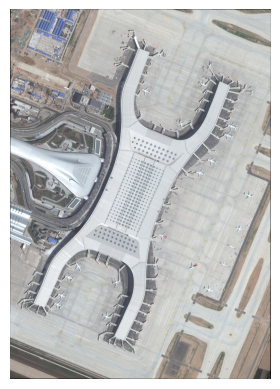

In [ ]:
image = cv2.imread('/kaggle/input/dota-data/DOTA/train/images/P0000.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
image.shape

(5502, 3875, 3)

In [ ]:
def split_image(image_path, tile_size=512, stride=512):
    img = cv2.imread(image_path)
    tiles = []
    h, w, _ = img.shape

    for y in range(0, h, stride):
        for x in range(0, w, stride):
            tile = img[y:y+tile_size, x:x+tile_size]
            if tile.shape[0] == tile_size and tile.shape[1] == tile_size:
                tiles.append(tile)

    return tiles

In [ ]:
# splitImages = split_image("./images/P0000.png")

In [ ]:
# for i in range(len(splitImages)):
#     image_rgb = cv2.cvtColor(splitImages[i], cv2.COLOR_BGR2RGB)
#     plt.imshow(image_rgb)
#     plt.axis('off')
#     plt.show()

# Dataset preparation
### 1. Converting Big Aerial size data into small tiles of 512 * 512.
### 2. Also kept the 128 pixels as overlap size.

In [ ]:
IMAGE_DIR = './images'
ANNOTATION_DIR = './trainset_reclabelTxt'

OUTPUT_IMAGE_DIR = './tiles/images'
OUTPUT_LABEL_DIR = './tiles/labels'
METADATA_PATH = './metadata.json'

In [ ]:
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)


In [ ]:
SELECTED_CLASSES = ['plane', 'small-vehicle']

TILE_SIZE = 512
OVERLAP = 128
VISIBILITY_THRESHOLD = 0.5

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15


In [ ]:
def parse_annotation(file_path):
    objects = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 9:
                continue
            coords = list(map(float, parts[:8]))
            class_name = parts[8]
            difficulty = int(parts[9]) if len(parts) > 9 else 0
            if class_name in SELECTED_CLASSES:
                polygon = np.array(coords).reshape((4, 2))
                objects.append({
                    'polygon': polygon,
                    'class_name': class_name,
                    'difficulty': difficulty
                })
    return objects


In [ ]:
def tile_image_and_annotations(image_path, annotation_path, tile_size, overlap):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return []
    image_height, image_width = image.shape[:2]

    objects = parse_annotation(annotation_path)

    x_steps = list(range(0, image_width, tile_size - overlap))
    y_steps = list(range(0, image_height, tile_size - overlap))

    tile_metadata = []
    tile_count = 0

    for y in y_steps:
        for x in x_steps:
            x_start = x
            y_start = y
            x_end = min(x + tile_size, image_width)
            y_end = min(y + tile_size, image_height)

            tile = image[y_start:y_end, x_start:x_end]
            tile_h, tile_w = tile.shape[:2]

            tile_objects = []
            for obj in objects:
                full_polygon = Polygon(obj['polygon'])
                tile_polygon = Polygon([
                    [x_start, y_start],
                    [x_end, y_start],
                    [x_end, y_end],
                    [x_start, y_end]
                ])
                intersection = full_polygon.intersection(tile_polygon)
                if not intersection.is_empty:
                    visibility = intersection.area / full_polygon.area
                    if visibility >= VISIBILITY_THRESHOLD:
                        intersection_coords = np.array(intersection.exterior.coords) - [x_start, y_start]
                        tile_objects.append({
                            'polygon': intersection_coords[:-1],
                            'class_name': obj['class_name'],
                            'difficulty': obj['difficulty']
                        })

            if len(tile_objects) == 0:
                continue

            tile_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_{tile_count}.png"
            tile_image_path = os.path.join(OUTPUT_IMAGE_DIR, tile_filename)
            cv2.imwrite(tile_image_path, tile)

            label_filename = f"{os.path.splitext(os.path.basename(annotation_path))[0]}_{tile_count}.txt"
            tile_label_path = os.path.join(OUTPUT_LABEL_DIR, label_filename)
            with open(tile_label_path, 'w') as f:
                for obj in tile_objects:
                    coords = obj['polygon'].flatten()
                    line = ' '.join(map(str, coords.tolist()))
                    line += f" {obj['class_name']} {obj['difficulty']}\n"
                    f.write(line)

            tile_metadata.append({
                'image': tile_image_path,
                'label': tile_label_path,
                'objects': [{
                    'class_name': obj['class_name'],
                    'difficulty': obj['difficulty']
                } for obj in tile_objects]
            })

            tile_count += 1

    return tile_metadata


In [ ]:
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.tif'))]

all_tile_metadata = []

for image_file in tqdm(image_files):
    image_path = os.path.join(IMAGE_DIR, image_file)
    annotation_file = os.path.splitext(image_file)[0] + '.txt'
    annotation_path = os.path.join(ANNOTATION_DIR, annotation_file)

    if not os.path.exists(annotation_path):
        print(f"Annotation file not found for image {image_file}")
        continue

    tile_metadata = tile_image_and_annotations(image_path, annotation_path, TILE_SIZE, OVERLAP)
    all_tile_metadata.extend(tile_metadata)


  0%|          | 0/1411 [00:00<?, ?it/s]

# Model

In [ ]:
class DotaDatasetCnnModel(nn.Module):
    def __init__(self):
        super(DotaDatasetCnnModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class ImageCnnDota(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(images_dir))
        self.label_files = sorted(os.listdir(labels_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = os.path.join(self.labels_dir, self.label_files[idx])
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            parts = line.split()
            coords = list(map(float, parts[:8]))
            class_label = int(parts[8])

        if self.transform:
            image = self.transform(image)
        else:
            image = F.to_tensor(image)
        target = torch.tensor(class_label, dtype=torch.long)

        return image, target

In [ ]:
images_path = './tiles/images'
labels_path = './tiles/labels'

dataset = ImageCnnDota(images_dir=images_path, labels_dir=labels_path)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DotaDatasetCnnModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

In [ ]:
model_save_path = './imageCnnDota.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

scripted_model = torch.jit.script(model)
scripted_model.save('/imageCnnDota2.h5')
print("Model also saved in .h5 format.")